[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/pixeltable/pixeltable/blob/master/docs/release/tutorials/object-detection-in-videos.ipynb)&nbsp;&nbsp;
[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pixeltable/pixeltable/blob/master/docs/release/tutorials/object-detection-in-videos.ipynb)

# Object Detection in Videos

In this tutorial, we'll demonstrate how to use Pixeltable to do frame-by-frame object detection, made simple through Pixeltable's video-related functionality:
* automatic frame extraction
* running complex functions against frames (in this case, the YOLOX object detection models)
* reassembling frames back into videos
We'll be working with a single video file from Pixeltable's test data repository.

This tutorial assumes you've worked through the [Pixeltable Basics](https://pixeltable.github.io/pixeltable/tutorials/pixeltable-basics/) tutorial; if you haven't, it's probably a good idea to do so now.

## Creating a tutorial directory and table

First, let's make sure the packages we need for this tutorial are installed: Pixeltable itself, and the YOLOX object detection library.

In [1]:
%pip install -q pixeltable git+https://github.com/Megvii-BaseDetection/YOLOX@ac58e0a

Note: you may need to restart the kernel to use updated packages.


As we saw in the Pixeltable Basics tutorial, all data in Pixeltable is stored in tables, which in turn reside in directories. We'll begin by creating a `video_tutorial` directory.

In [1]:
import pixeltable as pxt

pxt.create_dir('video_tutorial', ignore_errors=True)

Connected to Pixeltable database at: postgresql://postgres:@/pixeltable?host=/Users/orm/.pixeltable/pgdata


We create a table for our videos, with a single column.

In [2]:
# Drop the tables if they exist, in case they were created by a previous
# run of the tutorial
pxt.drop_table('video_tutorial.frames', ignore_errors=True)
pxt.drop_table('video_tutorial.videos', ignore_errors=True)

# Create the `video_tutorial.videos` table
videos_table = pxt.create_table('video_tutorial.videos', {'video': pxt.VideoType()})

Created table `videos`.


In order to interact with the frames, we take advantage of Pixeltable's component view concept: we create a "view" of our video table that contains one row for each frame of each video in the table. Pixeltable provides the built-in `FrameIterator` class for this.

In [3]:
from pixeltable.iterators import FrameIterator

frames_view = pxt.create_view(
    'video_tutorial.frames',
    videos_table,
    # `fps` determines the frame rate; a value of `0`
    # indicates the native frame rate of the video.
    iterator=FrameIterator.create(video=videos_table.video, fps=0)
)

Created view `frames` with 0 rows, 0 exceptions.


You'll see that neither the `videos` table nor the `frames` view has any actual data yet, because we haven't yet added any videos to the table. However, the `frames` view is now configured to automatically track the `videos` table as new data shows up.

The new view is automatically configured with six columns:
- `pos` - a system column that is part of every component view
- `video` - the column inherited from our base table (all base table columns are visible in any of its views)
- `frame_idx`, `pos_msec`, `pos_frame`, `frame` - these four columns are created by the `FrameIterator` class.

Let's have a look at the new view:

In [4]:
frames_view

Column Name,Type,Computed With
pos,int,
frame_idx,int,
pos_msec,float,
pos_frame,float,
frame,image,
video,video,


We'll now insert a single row into the videos table, containing a video of a busy intersection in Bangkok.

In [5]:
videos_table.insert([{'video': 'https://raw.github.com/pixeltable/pixeltable/master/tests/data/videos/bangkok_half_res.mp4'}])

Inserting rows into `videos`: 1 rows [00:00, 282.71 rows/s]
Inserting rows into `frames`: 462 rows [00:00, 19562.16 rows/s]
Inserted 463 rows with 0 errors.


UpdateStatus(num_rows=463, num_computed_values=0, num_excs=0, updated_cols=[], cols_with_excs=[])

Notice that both the `videos` table and `frames` view were automatically updated, expanding the single video into 462 rows in the view. Let's have a look at `videos` first.

video
""

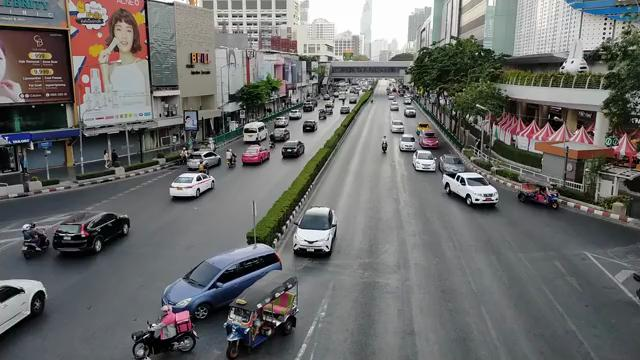

In [6]:
videos_table.show()

Now let's peek at the first five rows of `frames`:

pos,frame,width,height
0,,640,360
1,,640,360
2,,640,360
3,,640,360
4,,640,360

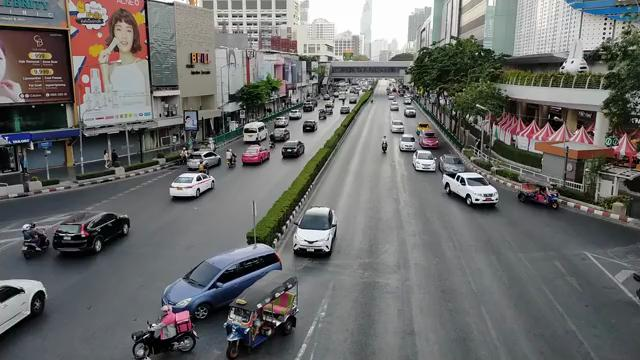
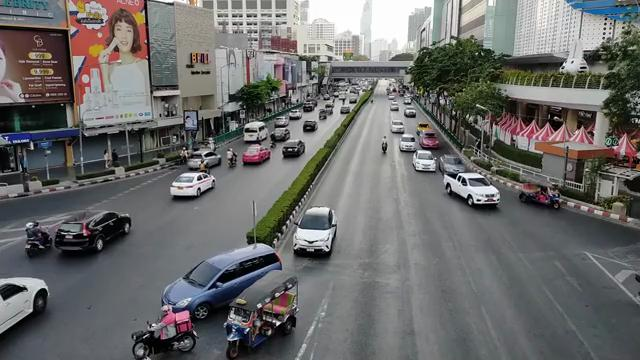
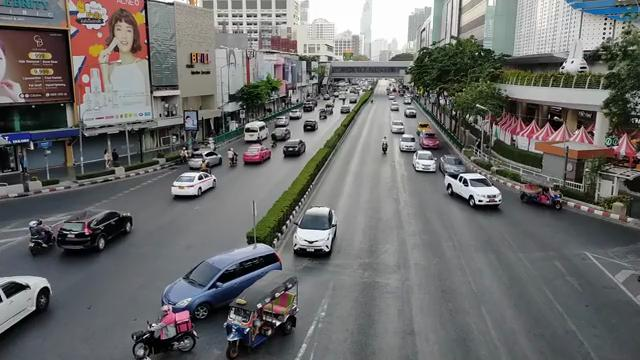
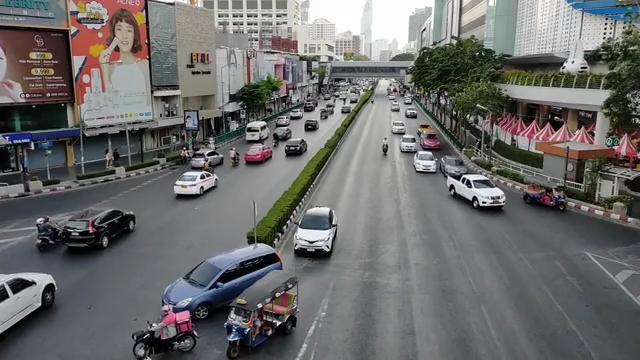
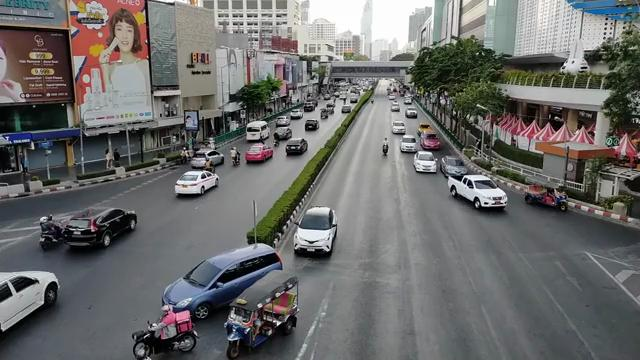

In [7]:
frames_view.select(frames_view.pos, frames_view.frame, frames_view.frame.width, frames_view.frame.height).show(5)

One advantage of using Pixeltable's component view mechanism is that Pixeltable does not physically store the frames. Instead, Pixeltable re-extracts the frames on retrieval using the frame index, which can be done very efficiently and avoids any storage overhead (which can be quite substantial for video frames).

## Object Detection with Pixeltable

Now let's apply an object detection model to our frames. Pixeltable includes built-in support for a number of models; we're going to use the YOLOX family of models, which are lightweight models with solid performance. We first import the `yolox` Pixeltable function.

In [8]:
from pixeltable.ext.functions.yolox import yolox

Pixeltable functions operate on columns and expressions using standard Python function call syntax. Here's an example that shows how we might experiment with applying one of the YOLOX models to the first few frames in our video, using Pixeltable's powerful `select` comprehension.

frame,col_1
,"{ bboxes: [[ 1.694e+02, 1.723e+02, 2.164e+02, 2.015e+02], [-3.002e-02, 2.778e+02, 4.835e+01, 3.392e+02], [ 5.217e+01, 2.105e+02, 1.284e+02, 2.569e+02], [ 1.588e+02, 2.448e+02, 2.851e+02, 3.203e+02], [ 2.394e+02, 1.447e+02, 2.706e+02, 1.664e+02], [ 2.919e+02, 2.047e+02, 3.380e+02, 2.596e+02], ..., [ 1.311e+02, 3.127e+02, 1.979e+02, 3.585e+02], [ 4.422e+02, 1.711e+02, 4.992e+02, 2.074e+02], [ 2.227e+02, 2.715e+02, 3.025e+02, 3.509e+02], [ 2.356e+02, 2.816e+02, 2.987e+02, 3.470e+02], [ 4.160e+02, 1.271e+02, 4.402e+02, 1.513e+02], [ 2.917e+02, 2.042e+02, 3.382e+02, 2.591e+02]], scores: [0.846,0.819,0.776,0.775,0.759,0.687,0.67 ,0.64 ,0.621,0.611,0.608,0.58 , 0.529], labels: [2,2,2,2,2,2,2,3,2,2,2,2,7] }"
,"{ bboxes: [[ 1.694e+02, 1.723e+02, 2.164e+02, 2.015e+02], [-3.002e-02, 2.778e+02, 4.835e+01, 3.392e+02], [ 5.217e+01, 2.105e+02, 1.284e+02, 2.569e+02], [ 1.588e+02, 2.448e+02, 2.851e+02, 3.203e+02], [ 2.394e+02, 1.447e+02, 2.706e+02, 1.664e+02], [ 2.919e+02, 2.047e+02, 3.380e+02, 2.596e+02], ..., [ 1.311e+02, 3.127e+02, 1.979e+02, 3.585e+02], [ 4.422e+02, 1.711e+02, 4.992e+02, 2.074e+02], [ 2.227e+02, 2.715e+02, 3.025e+02, 3.509e+02], [ 2.356e+02, 2.816e+02, 2.987e+02, 3.470e+02], [ 4.160e+02, 1.271e+02, 4.402e+02, 1.513e+02], [ 2.917e+02, 2.042e+02, 3.382e+02, 2.591e+02]], scores: [0.846,0.819,0.776,0.775,0.759,0.687,0.67 ,0.64 ,0.621,0.611,0.608,0.58 , 0.529], labels: [2,2,2,2,2,2,2,3,2,2,2,2,7] }"
,"{ bboxes: [[ 1.694e+02, 1.723e+02, 2.164e+02, 2.015e+02], [-3.002e-02, 2.778e+02, 4.835e+01, 3.392e+02], [ 5.217e+01, 2.105e+02, 1.284e+02, 2.569e+02], [ 1.588e+02, 2.448e+02, 2.851e+02, 3.203e+02], [ 2.394e+02, 1.447e+02, 2.706e+02, 1.664e+02], [ 2.919e+02, 2.047e+02, 3.380e+02, 2.596e+02], ..., [ 1.311e+02, 3.127e+02, 1.979e+02, 3.585e+02], [ 4.422e+02, 1.711e+02, 4.992e+02, 2.074e+02], [ 2.227e+02, 2.715e+02, 3.025e+02, 3.509e+02], [ 2.356e+02, 2.816e+02, 2.987e+02, 3.470e+02], [ 4.160e+02, 1.271e+02, 4.402e+02, 1.513e+02], [ 2.917e+02, 2.042e+02, 3.382e+02, 2.591e+02]], scores: [0.846,0.819,0.776,0.775,0.759,0.687,0.67 ,0.64 ,0.621,0.611,0.608,0.58 , 0.529], labels: [2,2,2,2,2,2,2,3,2,2,2,2,7] }"

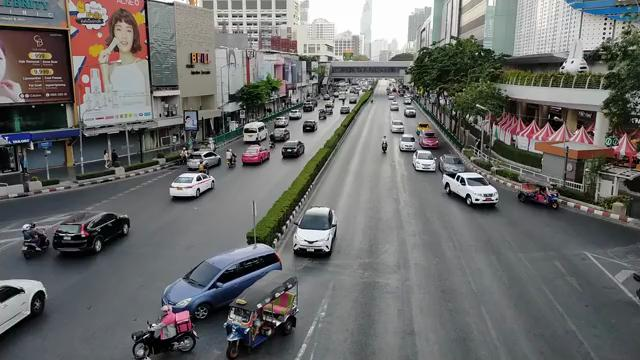
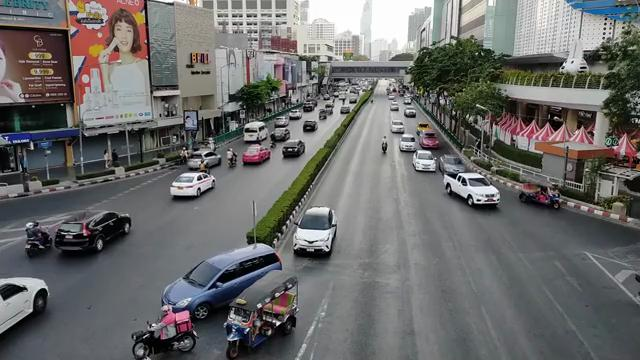
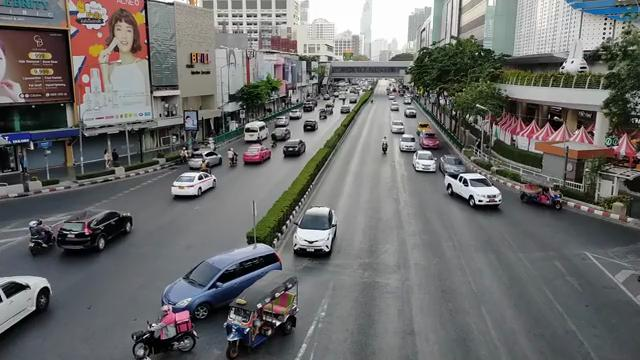

In [9]:
# Show the results of applying the `yolox_tiny` model to the first few frames in the table.

frames_view.select(frames_view.frame, yolox(frames_view.frame, model_id='yolox_tiny')).show(3)

It may appear that we just ran the YOLOX inference over the entire view of 462 frames, but remember that Pixeltable evaluates expressions lazily: in this case, it only ran inference over the 3 frames that we actually displayed.

The inference output looks like what we'd expect, so let's add a _computed column_ that runs inference over the entire view (we first encountered computed columns in the Pixeltable Basics tutorial). Remember that once a computed column is created, Pixeltable will update it incrementally any time new rows are added to the view. This is a convenient way to incorporate inference (and other operations) into data workflows.

In [10]:
# Create a computed column to compute detections using the `yolox_tiny` model.
# We'll adjust the confidence threshold down a bit (the default is 0.5) to pick up even more
# bounding boxes.

frames_view['detect_yolox_tiny'] = yolox(frames_view.frame, model_id='yolox_tiny', threshold=0.25)

Computing cells: 100%|████████████████████████████████████████| 462/462 [00:13<00:00, 33.06 cells/s]
Added 462 column values with 0 errors.


The new column is now part of the schema of the `frames` view:

In [11]:
frames_view

Column Name,Type,Computed With
pos,int,
frame_idx,int,
pos_msec,float,
pos_frame,float,
frame,image,
detect_yolox_tiny,json,"yolox(frame, threshold=0.25, model_id='yolox_tiny')"
video,video,


The data in the computed column is now stored for fast retrieval.

frame,detect_yolox_tiny
,"{ bboxes: [[ 1.694e+02, 1.723e+02, 2.164e+02, 2.015e+02], [-3.002e-02, 2.778e+02, 4.835e+01, 3.392e+02], [ 5.217e+01, 2.105e+02, 1.284e+02, 2.569e+02], [ 1.588e+02, 2.448e+02, 2.851e+02, 3.203e+02], [ 2.394e+02, 1.447e+02, 2.706e+02, 1.664e+02], [ 2.919e+02, 2.047e+02, 3.380e+02, 2.596e+02], ..., [ 2.222e+02, 1.491e+02, 2.386e+02, 1.701e+02], [ 2.429e+02, 1.232e+02, 2.681e+02, 1.446e+02], [ 1.303e+02, 3.121e+02, 1.974e+02, 3.589e+02], [ 2.207e+02, 2.748e+02, 2.996e+02, 3.552e+02], [ 1.823e+02, 1.498e+02, 2.021e+02, 1.668e+02], [ 5.425e+02, 1.906e+02, 5.610e+02, 2.099e+02]], labels: [2,2,2,2,2,2,...,2,2,2,7,2,2], scores: [0.846,0.819,0.776,0.775,0.759,0.687,...,0.334,0.314,0.314,0.262,0.261, 0.253] }"
,"{ bboxes: [[ 1.694e+02, 1.723e+02, 2.164e+02, 2.015e+02], [-3.002e-02, 2.778e+02, 4.835e+01, 3.392e+02], [ 5.217e+01, 2.105e+02, 1.284e+02, 2.569e+02], [ 1.588e+02, 2.448e+02, 2.851e+02, 3.203e+02], [ 2.394e+02, 1.447e+02, 2.706e+02, 1.664e+02], [ 2.919e+02, 2.047e+02, 3.380e+02, 2.596e+02], ..., [ 2.222e+02, 1.491e+02, 2.386e+02, 1.701e+02], [ 2.429e+02, 1.232e+02, 2.681e+02, 1.446e+02], [ 1.303e+02, 3.121e+02, 1.974e+02, 3.589e+02], [ 2.207e+02, 2.748e+02, 2.996e+02, 3.552e+02], [ 1.823e+02, 1.498e+02, 2.021e+02, 1.668e+02], [ 5.425e+02, 1.906e+02, 5.610e+02, 2.099e+02]], labels: [2,2,2,2,2,2,...,2,2,2,7,2,2], scores: [0.846,0.819,0.776,0.775,0.759,0.687,...,0.334,0.314,0.314,0.262,0.261, 0.253] }"
,"{ bboxes: [[ 1.694e+02, 1.723e+02, 2.164e+02, 2.015e+02], [-3.002e-02, 2.778e+02, 4.835e+01, 3.392e+02], [ 5.217e+01, 2.105e+02, 1.284e+02, 2.569e+02], [ 1.588e+02, 2.448e+02, 2.851e+02, 3.203e+02], [ 2.394e+02, 1.447e+02, 2.706e+02, 1.664e+02], [ 2.919e+02, 2.047e+02, 3.380e+02, 2.596e+02], ..., [ 2.222e+02, 1.491e+02, 2.386e+02, 1.701e+02], [ 2.429e+02, 1.232e+02, 2.681e+02, 1.446e+02], [ 1.303e+02, 3.121e+02, 1.974e+02, 3.589e+02], [ 2.207e+02, 2.748e+02, 2.996e+02, 3.552e+02], [ 1.823e+02, 1.498e+02, 2.021e+02, 1.668e+02], [ 5.425e+02, 1.906e+02, 5.610e+02, 2.099e+02]], labels: [2,2,2,2,2,2,...,2,2,2,7,2,2], scores: [0.846,0.819,0.776,0.775,0.759,0.687,...,0.334,0.314,0.314,0.262,0.261, 0.253] }"

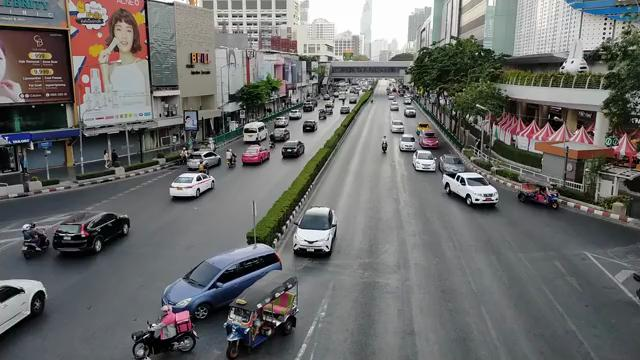
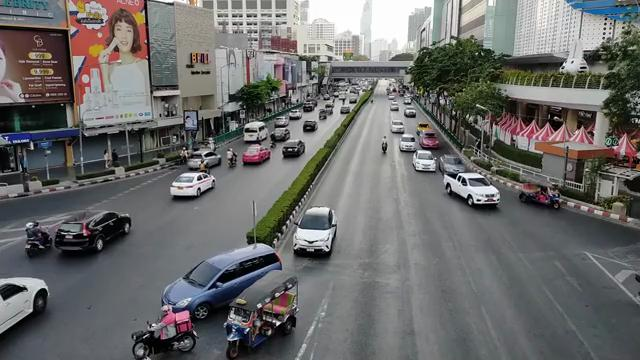
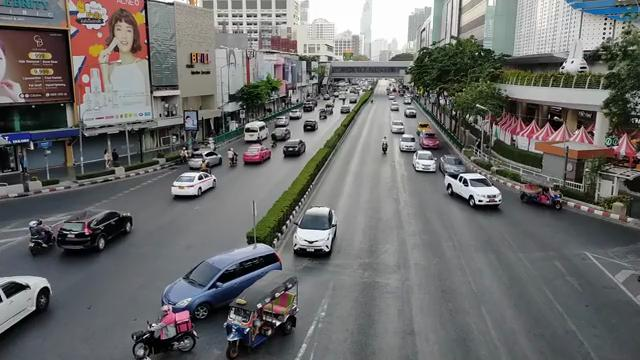

In [12]:
frames_view.select(frames_view.frame, frames_view.detect_yolox_tiny).show(3)

Now let's create a new set of images, in which we superimpose the detected bounding boxes on top of the original images. There's no built-in Pixeltable function to do this, but we can easily create our own. We'll use the `@pxt.udf` decorator for this, as we first saw in the Pixeltable Basics tutorial.

In [13]:
import PIL.Image
import PIL.ImageDraw

@pxt.udf
def draw_boxes(img: PIL.Image.Image, boxes: list[list[float]]) -> PIL.Image.Image:
    result = img.copy()  # Create a copy of `img`
    d = PIL.ImageDraw.Draw(result)
    for box in boxes:
        d.rectangle(box, width=3)  # Draw bounding box rectangles on the copied image
    return result

This function takes two arguments, `img` and `boxes`, and returns the new, annotated image. We could create a new computed column to hold the annotated images, but we don't have to; sometimes it's easier just to use a `select` comprehension, as we did when we were first experimenting with the detection model.

frame,col_1
,

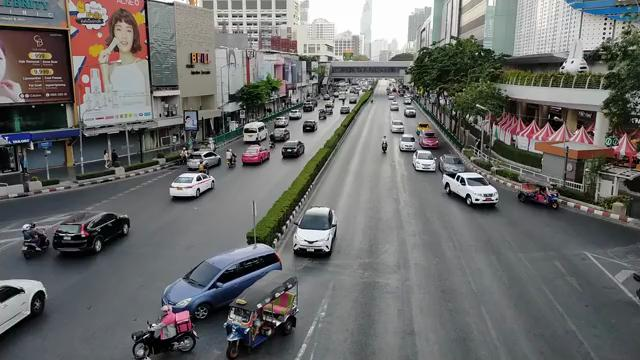
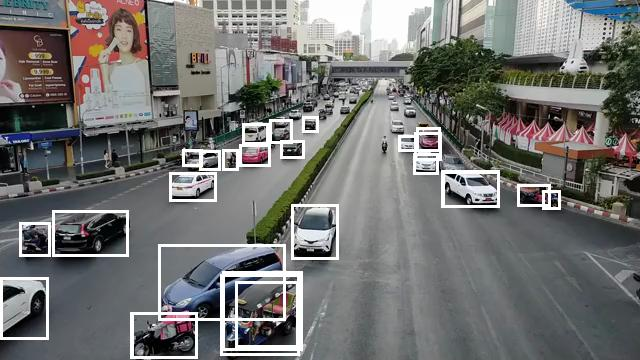

In [14]:
frames_view.select(frames_view.frame, draw_boxes(frames_view.frame, frames_view.detect_yolox_tiny.bboxes)).show(1)

Our `select` comprehension ranged over the entire table, but just as before, Pixeltable computes the output lazily: image operations are performed at retrieval time, so in this case, Pixeltable drew the annotations just for the one frame that we actually displayed.

Looking at individual frames gives us some idea of how well our detection algorithm works, but it would be more instructive to turn the visualization output back into a video.

We do that with the built-in function `make_video()`, which is an aggregation function that takes a frame index (actually: any expression that can be used to order the frames; a timestamp would also work) and an image, and then assembles the sequence of images into a video.

col_0
""

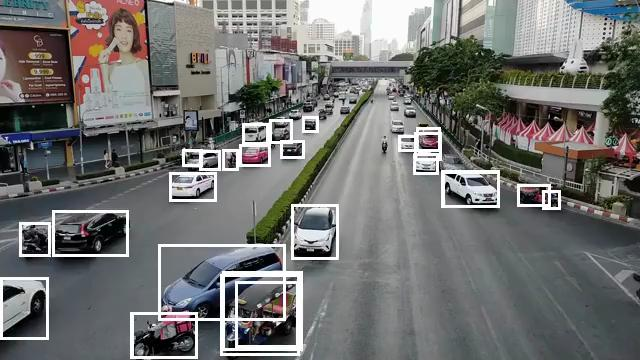

In [15]:
frames_view.select(pxt.functions.make_video(
    frames_view.pos, draw_boxes(frames_view.frame, frames_view.detect_yolox_tiny.bboxes)
)).group_by(videos_table).show(1)

## Comparing Object Detection Models

Now suppose we want to experiment with a more powerful object detection model, to see if there is any improvement in detection quality. We can create an additional column to hold the new inferences. The larger model takes longer to download and run, so please be patient.

In [16]:
# Here we use the larger `yolox_m` (medium) model.

frames_view['detect_yolox_m'] = yolox(frames_view.frame, model_id='yolox_m', threshold=0.25)

Computing cells: 100%|████████████████████████████████████████| 462/462 [01:56<00:00,  3.97 cells/s]
Added 462 column values with 0 errors.


Let's see the results of the two models side-by-side.

col_0,col_1
,

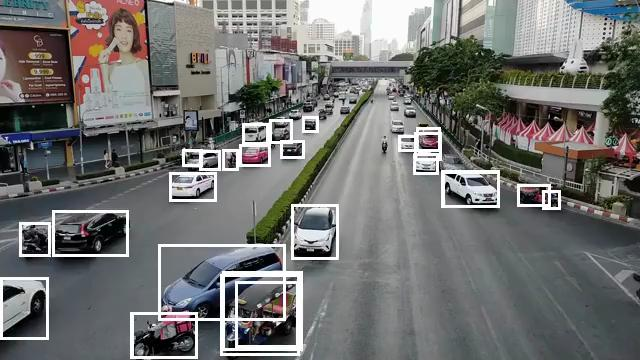
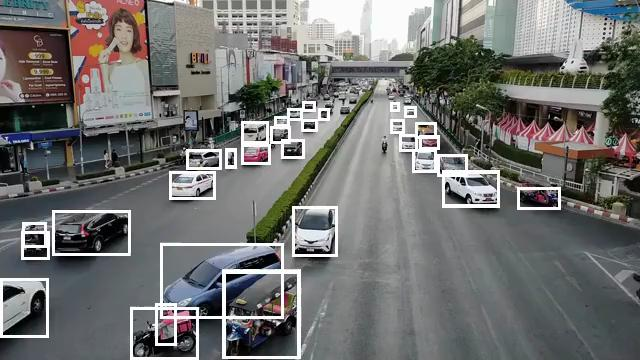

In [17]:
frames_view.select(pxt.functions.make_video(
    frames_view.pos, draw_boxes(frames_view.frame, frames_view.detect_yolox_tiny.bboxes)
), pxt.functions.make_video(
    frames_view.pos, draw_boxes(frames_view.frame, frames_view.detect_yolox_m.bboxes)
)).group_by(videos_table).show(1)

Running the videos side-by-side, we can see that the larger model is higher in quality: less flickering, with more stable boxes from frame to frame.

## Evaluating Models Against a Ground Truth

In order to do a quantitative evaluation of model performance, we need a ground truth to compare them against. Let's generate some (synthetic) "ground truth" data by running against the largest YOLOX model available. It will take even longer to cache and evaluate this model.

In [18]:
frames_view['detect_yolox_x'] = yolox(frames_view.frame, model_id='yolox_x', threshold=0.25)

Computing cells: 100%|████████████████████████████████████████| 462/462 [08:01<00:00,  1.04s/ cells]
Added 462 column values with 0 errors.


Let's have a look at our enlarged view, now with three `detect` columns.

In [19]:
frames_view

Column Name,Type,Computed With
pos,int,
frame_idx,int,
pos_msec,float,
pos_frame,float,
frame,image,
detect_yolox_tiny,json,"yolox(frame, threshold=0.25, model_id='yolox_tiny')"
detect_yolox_m,json,"yolox(frame, threshold=0.25, model_id='yolox_m')"
detect_yolox_x,json,"yolox(frame, threshold=0.25, model_id='yolox_x')"
video,video,


We're going to be evaluating the generated detections with the commonly-used [mean average precision](https://learnopencv.com/mean-average-precision-map-object-detection-model-evaluation-metric/) metric (mAP).

The mAP metric is based on per-frame metrics, such as true and false positives per detected class, which are then aggregated into a single (per-class) number. In Pixeltable, functionality is available via the `eval_detections()` and `mean_ap()` built-in functions.

In [20]:
from pixeltable.functions.eval import eval_detections, mean_ap

frames_view['eval_yolox_tiny'] = eval_detections(
    pred_bboxes=frames_view.detect_yolox_tiny.bboxes,
    pred_labels=frames_view.detect_yolox_tiny.labels,
    pred_scores=frames_view.detect_yolox_tiny.scores,
    gt_bboxes=frames_view.detect_yolox_x.bboxes,
    gt_labels=frames_view.detect_yolox_x.labels
)

frames_view['eval_yolox_m'] = eval_detections(
    pred_bboxes=frames_view.detect_yolox_m.bboxes,
    pred_labels=frames_view.detect_yolox_m.labels,
    pred_scores=frames_view.detect_yolox_m.scores,
    gt_bboxes=frames_view.detect_yolox_x.bboxes,
    gt_labels=frames_view.detect_yolox_x.labels
)

Computing cells: 100%|███████████████████████████████████████| 462/462 [00:00<00:00, 901.95 cells/s]
Added 462 column values with 0 errors.
Computing cells: 100%|██████████████████████████████████████| 462/462 [00:00<00:00, 1054.49 cells/s]
Added 462 column values with 0 errors.


Let's take a look at the output.

In [21]:
frames_view.select(frames_view.eval_yolox_tiny, frames_view.eval_yolox_m).show(1)

eval_yolox_tiny,eval_yolox_m
"[ { fp: [], tp: [], class: 0, scores: [], min_iou: 0.5, num_gts: 4 }, { fp: [0,0,0,0,0,0,...,1,1,0,1,1,1], tp: [1,1,1,1,1,1,...,0,0,1,0,0,0], class: 2, scores: [0.846,0.819,0.776,0.775,0.759,0.687,...,0.337,0.334,0.314,0.314,0.261, 0.253], min_iou: 0.5, num_gts: 26 }, { fp: [0,0], tp: [1,1], class: 3, scores: [0.64 ,0.398], min_iou: 0.5, num_gts: 4 }, { fp: [1,0,0], tp: [0,1,1], class: 7, scores: [0.529,0.457,0.262], min_iou: 0.5, num_gts: 4 }, { fp: [], tp: [], class: 62, scores: [], min_iou: 0.5, num_gts: 1 } ]","[ { fp: [0,0,0], tp: [1,1,1], class: 0, scores: [0.461,0.329,0.29 ], min_iou: 0.5, num_gts: 4 }, { fp: [0,0,0,0,0,0,...,0,1,0,0,0,0], tp: [1,1,1,1,1,1,...,1,0,1,1,1,1], class: 2, scores: [0.93 ,0.902,0.895,0.868,0.862,0.862,...,0.483,0.467,0.446,0.432,0.375, 0.303], min_iou: 0.5, num_gts: 26 }, { fp: [0,0,0,0], tp: [1,1,1,1], class: 3, scores: [0.852,0.702,0.652,0.408], min_iou: 0.5, num_gts: 4 }, { fp: [0,0], tp: [1,1], class: 7, scores: [0.749,0.433], min_iou: 0.5, num_gts: 4 }, { fp: [], tp: [], class: 62, scores: [], min_iou: 0.5, num_gts: 1 } ]"


The computation of the mAP metric is now simply a query over the evaluation output, aggregated with the `mean_ap()` function.

In [22]:
frames_view.select(mean_ap(frames_view.eval_yolox_tiny), mean_ap(frames_view.eval_yolox_m)).show()

col_0,col_1
"{0: 0.129, 2: 0.634, 3: 0.276, 7: 0.116, 62: 0., 58: 0., 5: 0.004, 9: 0., 8: 0.}","{0: 0.587, 2: 0.904, 3: 0.738, 7: 0.459, 62: 0., 58: 0., 5: 0.556, 13: 0., 1: 0.}"


This two-step process allows you to compute mAP at every granularity: over your entire dataset, only for specific videos, only for videos that pass a certain filter, etc. Moreover, you can compute this metric any time, not just during training, and use it to guide your understanding of your dataset and how it affects the quality of your models.